In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        display(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

'/kaggle/input/titanic/train.csv'

'/kaggle/input/titanic/gender_submission.csv'

'/kaggle/input/titanic/test.csv'

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
display(train.head(5))
display(test.head(5))
display(gender_submission.head(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
# SexとEmbarkedをOne-Hotエンコーディング
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

# 使用しない列の削除 axisで方向を定義 inplaceで新しいDFを作成せず、元のDFを書き換える
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# trainの表示
display(train.head())

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [5]:
X_train = train.drop(['Survived'], axis=1)  # X_trainではtrainの答えであるSurvived列を消去
Y_train = train['Survived']  # Y_trainではtrainの答えであるSurvived列を代入

In [6]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, Y_train, test_size=0.33, random_state=0)

# lab.Datasetでtrainとvalidを作っておく
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

# パラメータを定義
lgbm_params = {'objective': 'binary'}

# lgb.trainで学習
evals_result = {}
gbm = lgb.train(params = lgbm_params,
                train_set = lgb_train,
                valid_sets= [lgb_train, lgb_eval],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=10);

Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.426533	valid_1's binary_logloss: 0.465153
[20]	training's binary_logloss: 0.350077	valid_1's binary_logloss: 0.419539
[30]	training's binary_logloss: 0.303469	valid_1's binary_logloss: 0.40614
[40]	training's binary_logloss: 0.268824	valid_1's binary_logloss: 0.402566
[50]	training's binary_logloss: 0.241557	valid_1's binary_logloss: 0.409918
[60]	training's binary_logloss: 0.220422	valid_1's binary_logloss: 0.415006
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.268824	valid_1's binary_logloss: 0.402566


In [7]:
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)

(596, 10) (596,) (295, 10) (295,)


In [8]:
# valid_xについて推論
oof = (gbm.predict(valid_x) > 0.5).astype(int)
print('score', round(accuracy_score(valid_y, oof)*100,2)) 

score 81.69


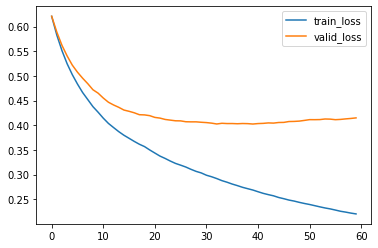

In [9]:
import matplotlib.pyplot as plt

plt.plot(evals_result['training']['binary_logloss'], label='train_loss')
plt.plot(evals_result['valid_1']['binary_logloss'], label='valid_loss')
plt.legend()

In [10]:
test_pred = (gbm.predict(test) > 0.5).astype(int)
sample_submission = gender_submission
sample_submission['Survived'] = test_pred
sample_submission.to_csv('lbgm_v1_submission.csv', index=False) 